In [1]:
using SpecialFunctions, IterTools, HardSphereDynamics, StatsBase # For Std Error.

In [2]:
?sem

search: sem isempty DenseMatrix SegmentationFault isperm basename systemerror



```
sem(x)
```

Return the standard error of the mean of collection `x`, i.e. `sqrt(var(x, corrected=true) / length(x))`.


Aqui abajo Rosa define todos los resultados téoricos para cualquier número de dimensiones, siempre
que no haya "sombras prohibidas" (es decir, que las bolas siempre quepan unas al lado de otras).

In [3]:

function SphereArea(n)
    return 2*(pi^(n/2))/gamma(n/2)
end

function NormalizationFactor(n, balls=2)
    d = 2*n
    return SphereArea(d)/SphereArea(d-1)*(d-1)
end

function Ak(boxdims,m)
    result = 0
    for aks in subsets(boxdims, m)
        result += prod(aks)
    end
    return result
end

function AvailableVolume(n, boxdims, r)
    vol = prod((2*boxdims).^2)
    for k in 0:n
        vol -= (4^n)*(pi)^(n/2-k/2)*r^(k+n)/gamma(k/2+n/2+1)*Ak(boxdims, n-k)*(-1)^k
    end
    return vol
end

function SphereCollisionArea(n, boxdims, r)
    area = 0 
    for k in 0:n
        area += 2^(2*n+1/2)*(pi^(n/2-k/2))*(r^(k+n-1))/gamma(k/2+n/2)*Ak(boxdims, n-k)*(-1)^k
    end
    return area
end

function WallCollisionArea(n, boxdims, r, dim)
    otherboxdims = deleteat!(copy(boxdims),dim)
    area = prod((2*otherboxdims).^2)*(2*boxdims[dim])
    for k in 0:(n-1)
        area -= 2^(2*n-2)*(pi^(n/2 - k/2))*(r^(k+n))/gamma(k/2+n/2+1)*(-1)^k*Ak(otherboxdims, n-1-k)
    end
    return area
end

function SphereCollisionTime(n, boxdimsh, r)
    boxdimsa = boxdimsh/2 .- r 
    return NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/SphereCollisionArea(n, boxdimsa, r)
end

function WallCollisionTime(n, boxdimsh, r, dim)
    boxdimsa = boxdimsh/2 .- r 
    return NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/WallCollisionArea(n, boxdimsa, r, dim)
end
    
function HoppingCollisionTime(n, boxdimsh, r, dim)
    boxdimsa = boxdimsh/2 .- r 
    otherboxdims = deleteat!(copy(boxdimsa),dim)
    #if r < minimum(boxdimsh)/4
        result= NormalizationFactor(n)*AvailableVolume(n, boxdimsa, r)/
           AvailableVolume(n-1, otherboxdims, r)/2^(2.5)/boxdimsa[dim]
    #else
    #    result=1.0
    #end
    
end

function CollisionTimesTheo(r, n=3, boxdimsh = [1.0, 1.5, 1.75])
    wall_times = []
    hop_times = []
    for dim in 1:n
        w = WallCollisionTime(n, boxdimsh, r, dim)
        push!(wall_times, w, w)
        push!(hop_times, HoppingCollisionTime(n, boxdimsh, r, dim))
    end
    result = hcat(r , SphereCollisionTime(n, boxdimsh, r), wall_times..., hop_times...)
    return result
end

CollisionTimesTheo (generic function with 3 methods)

In [94]:
using Parameters, Statistics, HardSphereDynamics, StaticArrays

function BallsRelativeSign(state)
    b1, b2 = state
    return broadcast(sign, b1.x - b2.x)
end

function mean_interval(times)
    return mean(diff(times))
end

h1 = 1.0
h2 = 1.5
h3 = 1.33
r = 0.1
rmax=  (h1+h3-√(2*h1*h3))/2   #maximal possible radius hopping in h2 direction

Nmax=10^6

function CollisionTimesSim(r, h1 = h1, h2 = h2, h3 = h3 ,num_collisions = Nmax)
    table = HardSphereDynamics.RectangularBox(SA[-h1/2, -h2/2, -h3/2],
                                              SA[+h1/2, +h2/2, +h3/2])

    n = 3
    spheres = 2
    fluid = HardSphereFluid{n,Float64}(table, spheres, r)
    initial_condition!(fluid.balls, table)

    # set up simulation:
    collision_type = ElasticCollision()
    flow_type = ExternalFieldFlow(SA[0.0, 0.0, 0.0])
    event_handler = AllToAll(fluid, flow_type)

    simulation =  HardSphereSimulation(
        fluid, event_handler, flow_type, collision_type);

    @unpack fluid, flow_dynamics, collision_dynamics, event_handler = simulation
    states = [deepcopy(fluid.balls)]
    times = [0.0]
    collision_types = [:none]
    partner2 = [0] 
    partner1 = [0]
    hopping_times = []
    hopping_directions = []
    for i in 1:num_collisions
        HardSphereDynamics.flow!(fluid.balls, (event_handler.next_collision_time - simulation.current_time), 
            flow_dynamics)
        simulation.current_time = event_handler.next_collision_time
        push!(collision_types, event_handler.collision_type)
        push!(partner2, event_handler.partner2)
        push!(partner1, event_handler.partner1)
        HardSphereDynamics.collide!(fluid, event_handler, collision_dynamics)
        HardSphereDynamics.find_collision!(event_handler, fluid, flow_dynamics)
        push!(states, deepcopy(fluid.balls))
        push!(times, simulation.current_time)
        prev, current = states[i:i+1]
        signprev, signcurrent = broadcast(BallsRelativeSign,[prev, current])
        if any(signprev .!= signcurrent)
            b1, b2 = states[i]
            start_time, final_time = times[i:i+1]
            hop_times = start_time .+( b1.x - b2.x)./(b2.v - b1.v)
            for (dir, time) in enumerate(hop_times)
                if all([time>=start_time, time<=final_time])
                    push!(hopping_times, time)
                    push!(hopping_directions, dir)
                end
            end
        end
    end
    
    wall_idx = (collision_types.== :wall_collision).&(partner1.== 1)
    wall_times = times[wall_idx];
    which_wall = partner2[wall_idx];
    wall_means = []
    
    # The std errros are no longer missin!
    wall_errors = []
    hop_errors  = []
    
    for i in 1:length(fluid.box.walls)
        
        enparedcorrecta=wall_times[which_wall .== i]
        error=sem(diff(enparedcorrecta))
        nn=length(enparedcorrecta)
     #   println( " En la pared $i, chocamos $nn veces")
        
        push!(wall_means,mean_interval(enparedcorrecta))
        push!(wall_errors, error)
        
    end
    
    hop_means = []
    hop_errors= []

    for i in 1:n
        
        cual_hop=hopping_times[hopping_directions .== i]
        ll=length(cual_hop)
        if ll > 2
            error=sem(diff(cual_hop))
        println("en el hop direccion $i, hopamos $ll veces con radio $r")
            push!(hop_means, mean_interval(cual_hop))
            push!(hop_errors, error)
        else
            push!(hop_means, NaN)
            push!(hop_errors, NaN)
        end
        
    end
    
    colision=times[collision_types.== :disc_collision]
    meandisc=mean_interval(colision)
    errorcol=sem(diff(colision))
    
    
    result=hcat(r, meandisc, errorcol,wall_means..., wall_errors..., hop_means..., hop_errors...)
    
    return result
        
end

CollisionTimesSim (generic function with 5 methods)

In [95]:
@time chin, pun, cuaz, el, eslam = CollisionTimesSim(0.21)

en el hop direccion 1, hopamos 210818 veces con radio 0.21
en el hop direccion 2, hopamos 77235 veces con radio 0.21
en el hop direccion 3, hopamos 106818 veces con radio 0.21
  9.871765 seconds (24.32 M allocations: 1.465 GiB, 8.74% gc time)


1×21 Array{Float64,2}:
 0.21  2.08693  0.00525713  3.06392  …  0.0028315  0.0153732  0.00896101

In [96]:
a=[0, 1, 2 ,3]
c=[9,3,2,1]
b=a[c.==76]
length(b)

0

In [97]:
rmax

0.34952467848499547

In [98]:
rs = 0.25:0.002:rmax
theo = vcat(broadcast(CollisionTimesTheo, rs)...);
sim = vcat(broadcast(CollisionTimesSim, rs)...);

en el hop direccion 1, hopamos 191390 veces con radio 0.25
en el hop direccion 2, hopamos 45161 veces con radio 0.25
en el hop direccion 3, hopamos 77647 veces con radio 0.25
en el hop direccion 1, hopamos 189316 veces con radio 0.252
en el hop direccion 2, hopamos 43900 veces con radio 0.252
en el hop direccion 3, hopamos 76888 veces con radio 0.252
en el hop direccion 1, hopamos 189190 veces con radio 0.254
en el hop direccion 2, hopamos 42678 veces con radio 0.254
en el hop direccion 3, hopamos 75630 veces con radio 0.254
en el hop direccion 1, hopamos 189354 veces con radio 0.256
en el hop direccion 2, hopamos 41609 veces con radio 0.256
en el hop direccion 3, hopamos 74666 veces con radio 0.256
en el hop direccion 1, hopamos 188466 veces con radio 0.258
en el hop direccion 2, hopamos 40360 veces con radio 0.258
en el hop direccion 3, hopamos 73243 veces con radio 0.258
en el hop direccion 1, hopamos 187638 veces con radio 0.26
en el hop direccion 2, hopamos 39000 veces con radio 0

en el hop direccion 1, hopamos 133437 veces con radio 0.34199999999999997
en el hop direccion 2, hopamos 31 veces con radio 0.34199999999999997
en el hop direccion 3, hopamos 32551 veces con radio 0.34199999999999997
en el hop direccion 1, hopamos 131687 veces con radio 0.344
en el hop direccion 2, hopamos 9 veces con radio 0.344
en el hop direccion 3, hopamos 31865 veces con radio 0.344
en el hop direccion 1, hopamos 129081 veces con radio 0.346
en el hop direccion 3, hopamos 30379 veces con radio 0.346
en el hop direccion 1, hopamos 125901 veces con radio 0.348
en el hop direccion 3, hopamos 28272 veces con radio 0.348


In [99]:
using JLD

In [100]:
nota="Los Resultados Teoricos y Simulados estan en dos tablas.
Prmero las bolas entre ellas.
Luego vienen en Teoricas los golpes con las paredes de un bola 
contra una pared asi: 
Columna   Pared
3         x positiva
4         x negativa
5         y positiva
6         y negativa
7         z positiva
8         z negativa
Luego vienen los hops, 
9         hop x
10         hop y
11        hop z
En las simulaciones, entre cada tipo de eventos, en el mismo orden, hay una grupo de columnas 
de errores estandar. Es decir, despues de choques entre bolas, una columna de error. Despues
de seis choques en paredes, vienen seis columnas de error. Y despues de tres columnas de hops, viene
tres columnas de error. 
"
otranota="La variable h contiene los tamaños de la caja. 
La variable Nmax el numero de collisiones total.
La variable rmax es el radio limite para cruzar en la direccion h2 (hopping in y direction)"
onde="simula3DInset-1e6-20210111.jld"

h=(h1,h2,h3)

save(onde, "nota01", nota, "nota02", otranota, 
    "teoricas" , theo, "numericas", sim, "h", h, "Nmax", Nmax, "rmax", rmax)

In [101]:
sim[:,17]

50-element Array{Float64,1}:
    5.113994884379807
    5.192652401302146
    5.278176309235044
    5.34877146082898
    5.442678567066202
    5.562699865498248
    5.645296089901815
    5.783807297871854
    5.859803587725667
    5.933861244194899
    6.156635514104477
    6.219716655223767
    6.437697089908438
    ⋮
   47.64368800171927
   64.88584253031387
   95.33437214557875
  144.8468544139872
  208.0071301510238
  332.63586286834834
  635.2688391702158
 1130.0260973421164
 3074.164877507639
 6790.829771735536
  NaN
  NaN

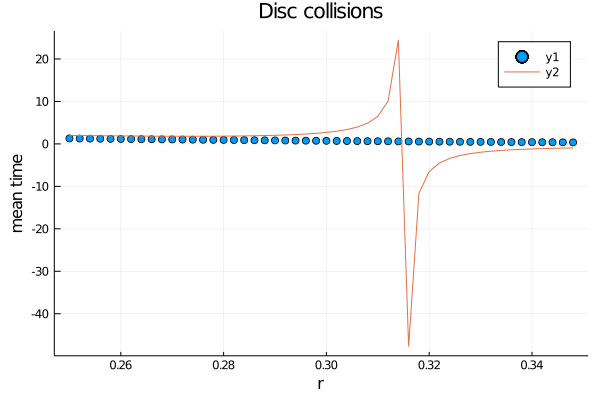

In [102]:
using Plots
scatter(rs,sim[:,2])
plot!(rs,theo[:,2])
title!("Disc collisions")
xlabel!("r")
ylabel!("mean time")

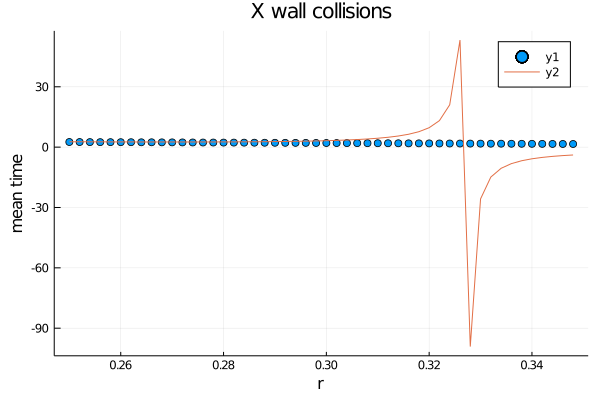

In [103]:
scatter(rs,sim[:,4])
plot!(rs,theo[:,3])
title!("X wall collisions")
xlabel!("r")
ylabel!("mean time")

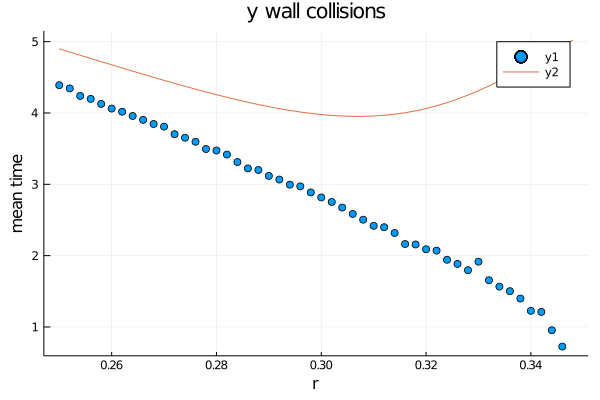

In [104]:
scatter(rs,sim[:,6])
plot!(rs,theo[:,5])
title!("y wall collisions")
xlabel!("r")
ylabel!("mean time")

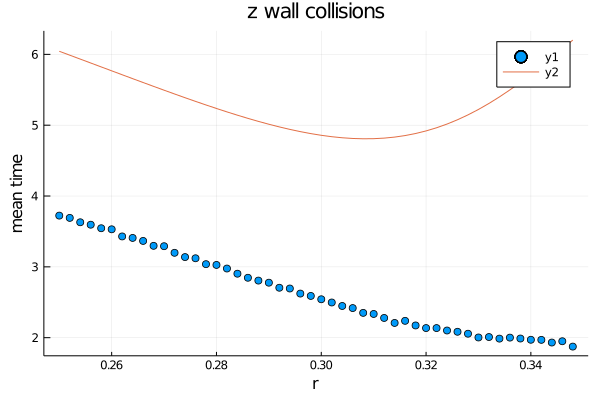

In [105]:
scatter(rs,sim[:,8])
plot!(rs,theo[:,7])
title!("z wall collisions")
xlabel!("r")
ylabel!("mean time")

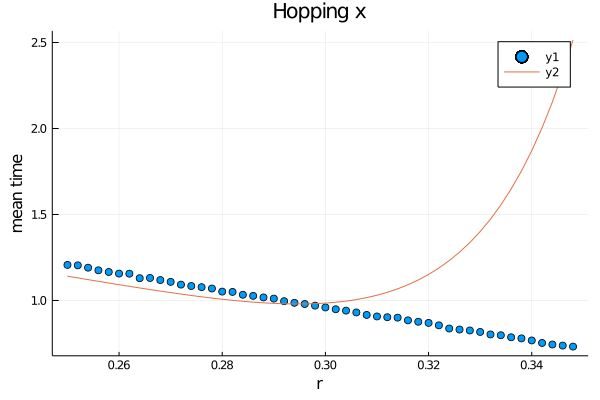

In [106]:
scatter(rs,sim[:,16] )
plot!(rs, theo[:, 9])
title!("Hopping x")
xlabel!("r")
ylabel!("mean time")

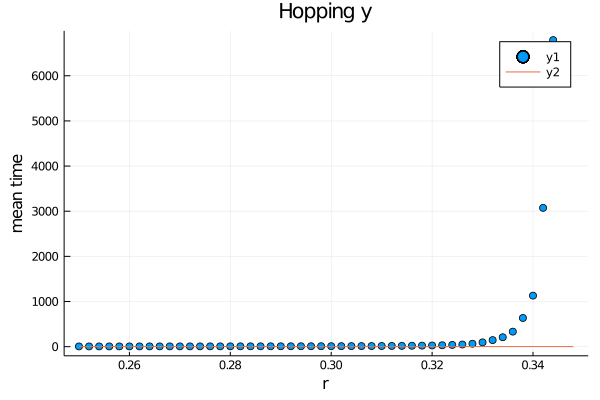

In [107]:
scatter(rs,sim[:,17])
plot!(rs, theo[:,10])
title!("Hopping y")
xlabel!("r")
ylabel!("mean time")

In [108]:
savefig("hop_axis_2_3D_inset.pdf")

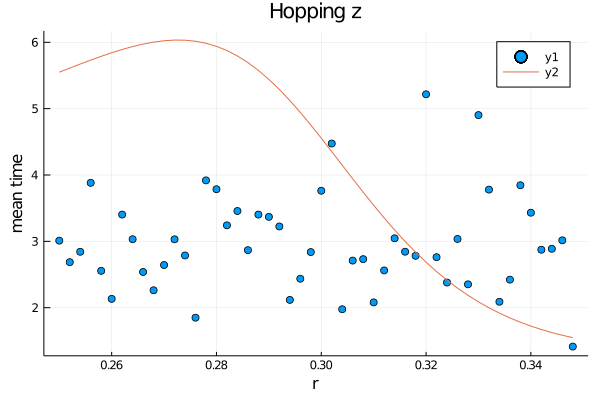

In [72]:
scatter(rs,sim[:,18] )
plot!(rs,theo[:,11])
title!("Hopping z")
xlabel!("r")
ylabel!("mean time")

A box with different dimensions

In [110]:
h1 = 1
h2 = 2
h3 = 3
theo2 = vcat(broadcast(function (r)  CollisionTimesTheo(r, 3, [h1,h2,h3]) end, rs)...);
sim2 = vcat(broadcast(function (r) CollisionTimesSim(r, h1, h2, h3) end , rs)...);

nota="Los Resultados Teoricos y Simulados estan en dos tablas.
Primera columna son los radios.
Prmero las bolas entre ellas.
Luego vienen en Teoricas los golpes con las paredes de un bola 
contra una pared asi: 
Columna   Pared
2         x positiva
3         x negativa
4         y positiva
5         y negativa
6         z positiva
7         z negativa
Luego vienen los hops, 
8         hop x
9         hop y
10        hop z
En las simulaciones, entre cada columna, en el mismo orden, hay una columna 
de errores estandar.
"
otranota="La variable h contiene los tamaños de la caja. La variable Nmax el numero de collisiones total."
onde="simulaRosa20201216-1930.jld"

h=(h1,h2,h3)

save(onde, "nota01", nota, "nota02", otranota, 
    "teoricas" , theo, "numericas", sim, "h", h, "Nmax", Nmax)

In [ ]:
using Plots
scatter(rs,[s[1] for s in sim2])
plot!(rs,[t[1] for t in theo2])
title!("Disc collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][1] for s in sim2])
plot!(rs,[t[2][1] for t in theo2])
title!("x wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][3] for s in sim2])
plot!(rs,[t[2][3] for t in theo2])
title!("y wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[2][5] for s in sim2])
plot!(rs,[t[2][5] for t in theo2])
title!("z wall collisions")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][1] for s in sim2])
plot!(rs,[t[3][1] for t in theo2])
title!("Hopping x")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][2] for s in sim])
plot!(rs,[t[3][2] for t in theo])
title!("Hopping y")
xlabel!("r")
ylabel!("mean time")

In [ ]:
scatter(rs,[s[3][3] for s in sim2])
plot!(rs,[t[3][3] for t in theo2])
title!("Hopping z")
xlabel!("r")
ylabel!("mean time")